In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch
import pickle

In [5]:
df = pd.read_csv('data/ckd_clean.csv')
df

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.000000,...,44.0,7800.0,5.200000,1.0,1.0,0.0,0.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,103.333333,...,38.0,6000.0,5.733333,0.0,0.0,0.0,0.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.000000,...,31.0,7500.0,2.833333,0.0,1.0,0.0,1.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.000000,...,32.0,6700.0,3.900000,1.0,0.0,0.0,1.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.000000,...,35.0,7300.0,4.600000,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,140.000000,...,47.0,6700.0,4.900000,0.0,0.0,0.0,0.0,0.0,0.0,0
396,42.0,70.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,75.000000,...,54.0,7800.0,6.200000,0.0,0.0,0.0,0.0,0.0,0.0,0
397,12.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,...,49.0,6600.0,5.400000,0.0,0.0,0.0,0.0,0.0,0.0,0
398,17.0,60.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,114.000000,...,51.0,7200.0,5.900000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [41]:
# Define the Decision Tree Classifier
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes = len(set(y))
        self.features = X.columns
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X.to_numpy()])

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        node = {"predicted_class": predicted_class}

        if depth < self.max_depth:
            idx, threshold = self._best_split(X, y)
            if idx is not None:
                indices_left = X.iloc[:, idx] < threshold
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node["feature_index"] = idx
                node["threshold"] = threshold
                node["left"] = self._grow_tree(X_left, y_left, depth + 1)
                node["right"] = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _best_split(self, X, y):
        best_idx, best_threshold = None, None
        best_gini = 1.0
        for idx in range(X.shape[1]):
            thresholds, classes = zip(*sorted(zip(X.iloc[:, idx], y)))
            num_left = [0] * self.n_classes
            num_right = Counter(classes)
            for i in range(1, len(y)):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(self.n_classes))
                gini_right = 1.0 - sum((num_right[x] / (len(y) - i)) ** 2 for x in range(self.n_classes))
                gini = (i * gini_left + (len(y) - i) * gini_right) / len(y)

                # Try adding a penalty if the feature is "age"
                if X.columns[idx] == "age":
                    gini += 0.1  # Adjust the penalty value as needed
                
                if thresholds[i] != thresholds[i - 1] and gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_threshold = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_threshold

    def _predict(self, inputs):
        node = self.tree
        while "feature_index" in node:
            if inputs[node["feature_index"]] < node["threshold"]:
                node = node["left"]
            else:
                node = node["right"]
        return node["predicted_class"]

# Define the Random Forest Classifier
class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y, X_test=None, y_test=None, epochs=10):
        """
        Train the Random Forest incrementally by adding trees over epochs.
        Calculate both training and validation loss after each epoch.
        """
        self.trees = []
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Add one tree per epoch
            bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
            X_bootstrap = X.iloc[bootstrap_indices]
            y_bootstrap = y.iloc[bootstrap_indices]
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

            # Calculate training loss
            y_pred_proba_train = self.predict_proba(X)
            train_loss = self._log_loss(y, y_pred_proba_train)
            train_losses.append(train_loss)

            # Calculate validation loss (if validation data is provided)
            if X_test is not None and y_test is not None:
                y_pred_proba_val = self.predict_proba(X_test)
                val_loss = self._log_loss(y_test, y_pred_proba_val)
                val_losses.append(val_loss)
                print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
            else:
                print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss:.4f}")

        return train_losses, val_losses

    def predict(self, X):
        """
        Predict the class for each sample in X.
        """
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return [Counter(tree_preds[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]

    def predict_proba(self, X):
        """
        Predict class probabilities for each sample in X.
        """
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        proba = np.zeros((X.shape[0], len(set(tree_preds.flatten()))))
        for i in range(X.shape[0]):
            counts = Counter(tree_preds[:, i])
            for cls, count in counts.items():
                proba[i, cls] = count / len(self.trees)
        return proba

    def _log_loss(self, y_true, y_pred_proba):
        """
        Compute the log loss for the given true labels and predicted probabilities.
        """
        n_samples = len(y_true)
        n_classes = y_pred_proba.shape[1]
        log_loss = 0.0
        for i in range(n_samples):
            for c in range(n_classes):
                if c == y_true.iloc[i]:
                    log_loss -= np.log(max(y_pred_proba[i, c], 1e-15))  # Avoid log(0)
        return log_loss / n_samples
    
# Function to compute feature importance
def compute_feature_importance(rf, X):
    feature_importance = np.zeros(X.shape[1])
    for tree in rf.trees:
        def traverse_tree(node, depth=0):
            if "feature_index" in node:
                feature_importance[node["feature_index"]] += 1
                traverse_tree(node["left"], depth + 1)
                traverse_tree(node["right"], depth + 1)
        traverse_tree(tree.tree)
    return feature_importance / sum(feature_importance)

Epoch 1/100 - Training Loss: 0.4317, Validation Loss: 0.8635
Epoch 2/100 - Training Loss: 0.1188, Validation Loss: 0.8635
Epoch 3/100 - Training Loss: 0.0136, Validation Loss: 0.0275
Epoch 4/100 - Training Loss: 0.0159, Validation Loss: 0.0296
Epoch 5/100 - Training Loss: 0.0127, Validation Loss: 0.0313
Epoch 6/100 - Training Loss: 0.0125, Validation Loss: 0.0242
Epoch 7/100 - Training Loss: 0.0109, Validation Loss: 0.0263
Epoch 8/100 - Training Loss: 0.0126, Validation Loss: 0.0296
Epoch 9/100 - Training Loss: 0.0135, Validation Loss: 0.0337
Epoch 10/100 - Training Loss: 0.0133, Validation Loss: 0.0389
Epoch 11/100 - Training Loss: 0.0135, Validation Loss: 0.0417
Epoch 12/100 - Training Loss: 0.0138, Validation Loss: 0.0428
Epoch 13/100 - Training Loss: 0.0133, Validation Loss: 0.0413
Epoch 14/100 - Training Loss: 0.0132, Validation Loss: 0.0425
Epoch 15/100 - Training Loss: 0.0132, Validation Loss: 0.0433
Epoch 16/100 - Training Loss: 0.0128, Validation Loss: 0.0412
Epoch 17/100 - Tr

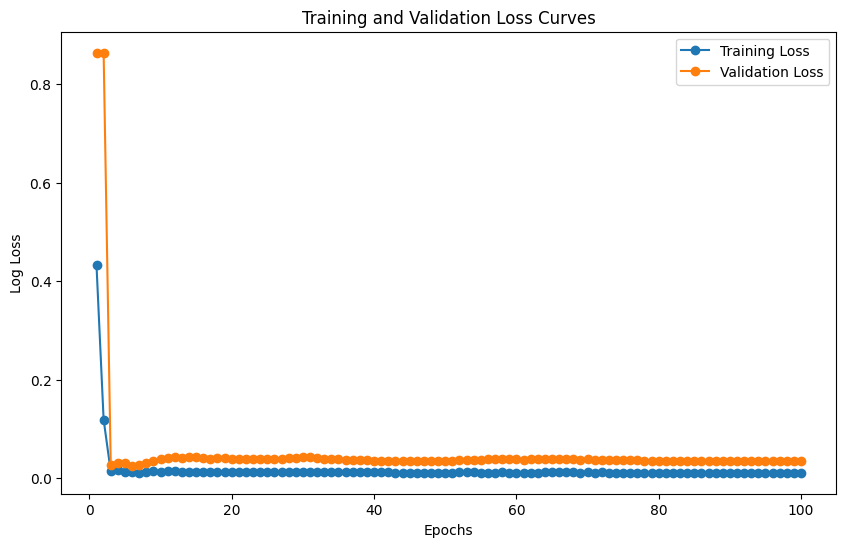

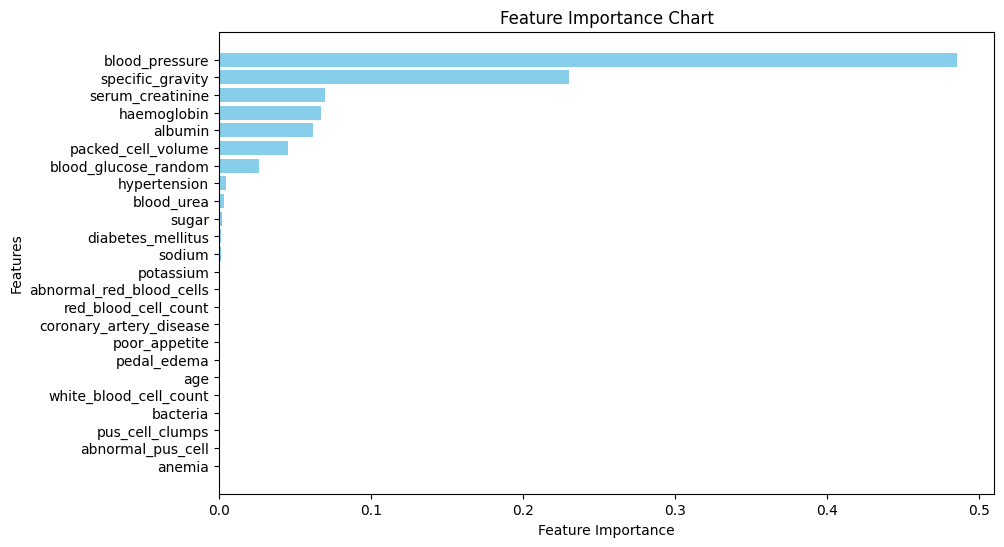

In [46]:
# Example usage
# Load dataset
data = pd.read_csv('data/ckd_clean.csv')

# Preprocess the data
X = data.drop(columns=['class'])
y = data['class']

# Split the data into training and testing sets
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the Random Forest on the training set
rf = RandomForest(n_estimators=100, max_depth=5)
train_losses, val_losses = rf.fit(X_train, y_train, X_test=X_test, y_test=y_test, epochs=100)

# Save the RandomForest model to a file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate accuracy on the test set
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

# Compute feature importance
feature_importance = compute_feature_importance(rf, X_train)

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Chart")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [45]:
# Load the RandomForest model from the file
with open('random_forest_model.pkl', 'rb') as file:
    loaded_rf = pickle.load(file)

# Load the new dataset to test accuracy of model on another similar dataset
# Assuming the new dataset is in the same format as the training data
# Load new dataset
ckd_new = pd.read_csv('data/ckd_new.csv')

# Preprocess the new dataset
X_new = ckd_new.drop(columns=['class'])
y_new = ckd_new['class']

# Make predictions on the new dataset
y_new_pred = loaded_rf.predict(X_new)

# Evaluate accuracy on the new dataset
new_accuracy = np.mean(y_new_pred == y_new)
print(f"Accuracy on new dataset: {new_accuracy}")

Accuracy on new dataset: 0.725
